In [34]:
"""
Part 1: Wikipedia Page Retrieval (Fixed with nested subsections)
"""
import wikipediaapi
import json

# Initialize Wikipedia API
wiki = wikipediaapi.Wikipedia(
    language='en',
    user_agent='EnvironmentKeywordMapping/1.0'
)

def get_all_subsections(sections):
    """
    Recursively extract all section titles including nested subsections.
    
    Args:
        sections: Wikipedia page sections
        
    Returns:
        List of all section titles (including nested)
    """
    titles = []
    for section in sections:
        titles.append(section.title)
        # Recursively get nested subsections
        if section.sections:
            titles.extend(get_all_subsections(section.sections))
    return titles

def get_wikipedia_data(keyword):
    """
    Get Wikipedia page and extract main text, subsections, and entities.
    
    Args:
        keyword: Search term
        
    Returns:
        Dictionary with page data
    """
    page = wiki.page(keyword)
    
    if not page.exists():
        print(f"Page not found for: {keyword}")
        return None
    
    # Get main text
    main_text = page.text
    
    # Get ALL subsection titles (including nested)
    subsections = get_all_subsections(page.sections)
    
    # Get clickable entities (links)
    entities = []
    for link in page.links.keys():
        # Skip Wikipedia system pages
        if not link.startswith(('Category:', 'File:', 'Wikipedia:', 'Help:', 'Template:')):
            entities.append(link)
    
    # Store everything
    result = {
        'keyword': keyword,
        'title': page.title,
        'url': page.fullurl,
        'main_text': main_text,
        'subsections': subsections,
        'entities': entities
    }
    
    return result

# Main execution
keywords = ["nature", "resilience", "sustainability", "climate change"]

print("Extracting Wikipedia data...")
all_data = {}

for keyword in keywords:
    print(f"\nProcessing: {keyword}")
    data = get_wikipedia_data(keyword)
    
    if data:
        all_data[keyword] = data
        
        # Show summary
        print(f"  Title: {data['title']}")
        print(f"  Text length: {len(data['main_text'])} chars")
        print(f"  Subsections: {len(data['subsections'])}")
        print(f"  Entities: {len(data['entities'])}")
        
        # Show first few subsections and entities
        print(f"  First 5 subsections: {data['subsections'][:5]}")
        print(f"  First 10 entities: {data['entities'][:10]}")
        
        # Save individual file
        filename = f"wikipedia_{keyword.replace(' ', '_')}.json"
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(data, f, indent=2, ensure_ascii=False)
        print(f"  Saved: {filename}")

# Save all data together
with open("wikipedia_all_keywords.json", 'w', encoding='utf-8') as f:
    json.dump(all_data, f, indent=2, ensure_ascii=False)

print("\nAll data saved to: wikipedia_all_keywords.json")
print("\nSummary:")
for keyword in keywords:
    if keyword in all_data:
        print(f"{keyword}: {len(all_data[keyword]['subsections'])} subsections, "
              f"{len(all_data[keyword]['entities'])} entities")

Extracting Wikipedia data...

Processing: nature
  Title: Nature
  Text length: 42246 chars
  Subsections: 25
  Entities: 849
  First 5 subsections: ['Etymology', 'Earth', 'Geology', 'Geological evolution', 'Historical perspective']
  First 10 entities: ['9th millennium BCE', 'Abiogenesis', 'Abiotic component', 'Academic discipline', 'Accelerating expansion of the universe', 'Adaptation', 'Aerobiology', 'Aesthetics', 'Africa', 'Age of Earth']
  Saved: wikipedia_nature.json

Processing: resilience
  Title: Resilience
  Text length: 3951 chars
  Subsections: 11
  Entities: 42
  First 5 subsections: ['Science', 'Ecology', 'Social sciences', 'Technology and engineering', 'Entertainment and media']
  First 10 entities: ['Awakened (album)', 'Chronicles of Alsea', 'Climate resilience', 'Community resilience', 'Crew Dragon Resilience', 'Cyber resilience', 'Ecological resilience', 'Elizabeth Edwards', 'Energy development', 'Hakuto-R Mission 2']
  Saved: wikipedia_resilience.json

Processing: su

Loaded: nature (42246 characters)
Loaded: resilience (3951 characters)
Loaded: sustainability (50855 characters)
Loaded: climate change (63055 characters)

Corpus created with 4 documents

Preprocessing corpus...
nature: 6551 -> 3761 tokens
resilience: 566 -> 365 tokens
sustainability: 7322 -> 4265 tokens
climate change: 9641 -> 5633 tokens

Creating TF-IDF vectors...
TF-IDF matrix shape: (4, 3446)
Vocabulary size: 3446

Calculating cosine similarity...


COSINE SIMILARITY MATRIX
                nature  resilience  sustainability  climate change
nature          1.0000      0.0115          0.2032          0.2844
resilience      0.0115      1.0000          0.0164          0.0149
sustainability  0.2032      0.0164          1.0000          0.2185
climate change  0.2844      0.0149          0.2185          1.0000


Pairwise Similarity Scores:
--------------------------------------------------
nature               vs resilience          : 0.0115
nature               vs sustainability      : 

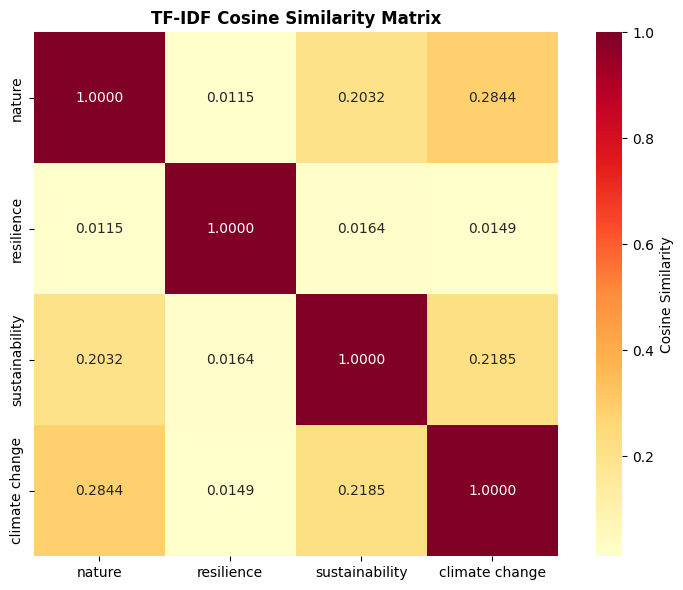


SAVING RESULTS
Similarity matrix saved to: similarity_matrix.csv
Formatted table saved to: similarity_table.txt
Heatmap saved to: similarity_heatmap.png


In [35]:
"""
Part 2: TF-IDF and Cosine Similarity Analysis
Create corpus from Wikipedia pages and calculate similarity between documents
"""

import json
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Download required NLTK data (uncomment if needed)
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

class CorpusAnalyzer:
    """Analyzes Wikipedia corpus using TF-IDF and cosine similarity"""
    
    def __init__(self, keywords):
        self.keywords = keywords
        self.corpus = []
        self.preprocessed_corpus = []
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        
    def preprocess_text(self, text):
        """Preprocess text: tokenize, lowercase, remove stopwords, lemmatize"""
        # Tokenize and lowercase
        tokens = word_tokenize(text.lower())
        
        # Remove stopwords and non-alphabetic tokens
        filtered = [token for token in tokens 
                    if token.isalpha() and token not in self.stop_words]
        
        # Lemmatize
        lemmatized = [self.lemmatizer.lemmatize(token) for token in filtered]
        
        return ' '.join(lemmatized)
    
    def load_corpus(self, filename):
        """Load Wikipedia data and create corpus"""
        with open(filename, 'r', encoding='utf-8') as f:
            wiki_data = json.load(f)
        
        # Build corpus - each Wikipedia page is one document
        for keyword in self.keywords:
            if keyword in wiki_data:
                # Get main_text from the data structure
                text = wiki_data[keyword].get('main_text', '')
                self.corpus.append(text)
                print(f"Loaded: {keyword} ({len(text)} characters)")
            else:
                self.corpus.append("")
                print(f"Warning: No data for '{keyword}'")
        
        print(f"\nCorpus created with {len(self.corpus)} documents\n")
    
    def preprocess_corpus(self):
        """Preprocess all documents in corpus"""
        print("Preprocessing corpus...")
        for i, doc in enumerate(self.corpus):
            preprocessed = self.preprocess_text(doc)
            self.preprocessed_corpus.append(preprocessed)
            print(f"{self.keywords[i]}: {len(doc.split())} -> {len(preprocessed.split())} tokens")
    
    def compute_similarity(self):
        """Create TF-IDF vectors and calculate cosine similarity"""
        # Create TF-IDF vectors
        print("\nCreating TF-IDF vectors...")
        vectorizer = TfidfVectorizer(
            max_features=5000,
            min_df=1,
            max_df=0.95
        )
        tfidf_matrix = vectorizer.fit_transform(self.preprocessed_corpus)
        
        print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
        print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")
        
        # Calculate cosine similarity
        print("\nCalculating cosine similarity...\n")
        similarity_matrix = cosine_similarity(tfidf_matrix)
        
        # Create DataFrame for better display
        df_similarity = pd.DataFrame(
            similarity_matrix,
            index=self.keywords,
            columns=self.keywords
        )
        
        return df_similarity


# Main execution
if __name__ == "__main__":
    # Define keywords from Question 1
    keywords = ["nature", "resilience", "sustainability", "climate change"]
    
    # Create analyzer
    analyzer = CorpusAnalyzer(keywords)
    
    # Load corpus from Question 1 output
    analyzer.load_corpus("wikipedia_all_keywords.json")
    
    # Preprocess documents
    analyzer.preprocess_corpus()
    
    # Compute similarity
    similarity_df = analyzer.compute_similarity()
    
    # Display results table
    print("\n" + "="*70)
    print("COSINE SIMILARITY MATRIX")
    print("="*70)
    print(similarity_df.round(4).to_string())
    print()
    
    # Show pairwise similarities
    print("\nPairwise Similarity Scores:")
    print("-" * 50)
    for i in range(len(keywords)):
        for j in range(i+1, len(keywords)):
            sim = similarity_df.iloc[i, j]
            print(f"{keywords[i]:20s} vs {keywords[j]:20s}: {sim:.4f}")
    
    # Create and display visualization
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(similarity_df, annot=True, fmt='.4f', cmap='YlOrRd', 
                square=True, cbar_kws={'label': 'Cosine Similarity'})
    plt.title('TF-IDF Cosine Similarity Matrix', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Save results
    print("\n" + "="*70)
    print("SAVING RESULTS")
    print("="*70)
    
    # Save similarity matrix as CSV
    similarity_df.to_csv("similarity_matrix.csv")
    print("Similarity matrix saved to: similarity_matrix.csv")
    
    # Save formatted table
    with open("similarity_table.txt", 'w') as f:
        f.write("COSINE SIMILARITY MATRIX\n")
        f.write("="*70 + "\n\n")
        f.write(similarity_df.round(4).to_string())
        f.write("\n\n")
        f.write("Pairwise Similarities:\n")
        f.write("-"*50 + "\n")
        for i in range(len(keywords)):
            for j in range(i+1, len(keywords)):
                sim = similarity_df.iloc[i, j]
                f.write(f"{keywords[i]:20s} vs {keywords[j]:20s}: {sim:.4f}\n")
    print("Formatted table saved to: similarity_table.txt")
    
    # Save heatmap
    plt.savefig('similarity_heatmap.png', dpi=300, bbox_inches='tight')
    print("Heatmap saved to: similarity_heatmap.png")
    plt.close()


QUESTION 3: SUBSECTION-BASED SIMILARITY

Extracting subsection titles...
nature: 25 subsections
resilience: 11 subsections
sustainability: 39 subsections
climate change: 48 subsections

Computing TF-IDF for Subsections...
TF-IDF matrix shape: (4, 203)
Vocabulary size: 203

Subsection Similarity Matrix:
                nature  resilience  sustainability  climate change
nature          1.0000      0.1499          0.1092          0.2776
resilience      0.1499      1.0000          0.0844          0.1519
sustainability  0.1092      0.0844          1.0000          0.1794
climate change  0.2776      0.1519          0.1794          1.0000

Saved to: similarity_subsections.csv

QUESTION 4: ENTITY-BASED SIMILARITY

Extracting entity links...
nature: 849 entities
resilience: 42 entities
sustainability: 720 entities
climate change: 840 entities

Computing TF-IDF for Entities...
TF-IDF matrix shape: (4, 2213)
Vocabulary size: 2213

Entity Similarity Matrix:
                nature  resilience  sust

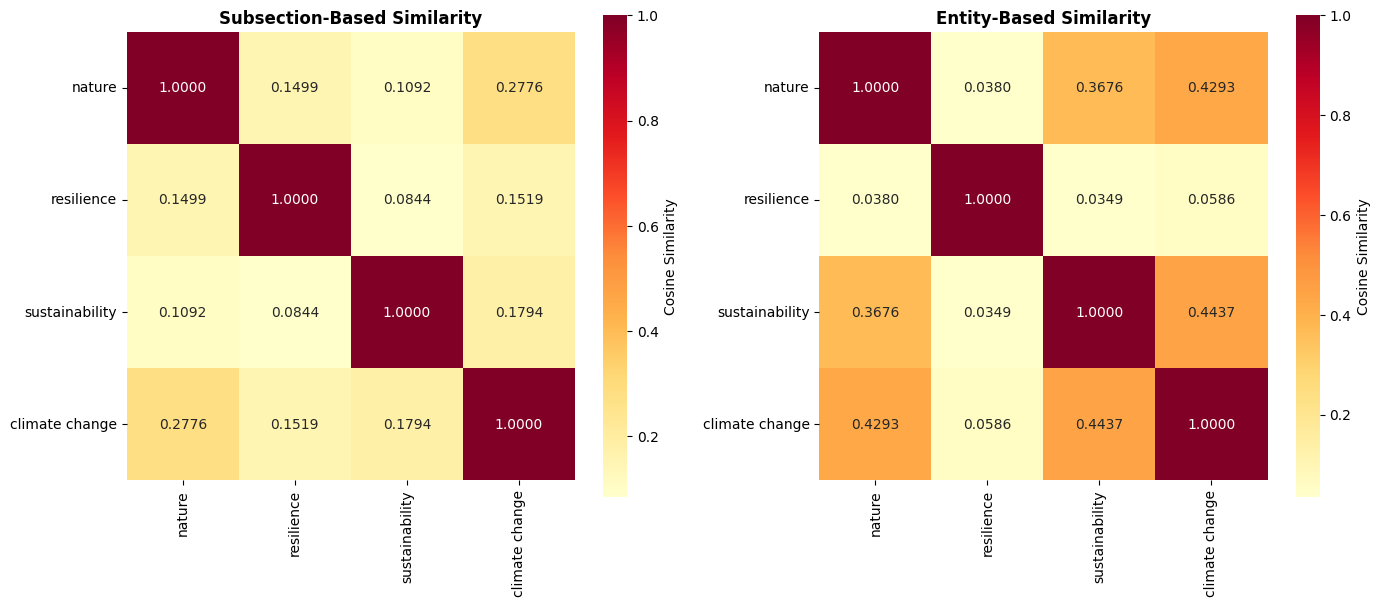


Heatmaps saved to: comparison_heatmaps.png


In [36]:
"""
Part 3-4: Subsection and Entity-Based Similarity Analysis
Repeat TF-IDF similarity using subsections and entities
"""

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

class SubsectionEntityAnalyzer:
    """Analyzes similarity using subsections and entities"""
    
    def __init__(self, keywords, data_file):
        self.keywords = keywords
        with open(data_file, 'r', encoding='utf-8') as f:
            self.data = json.load(f)
    
    def extract_subsection_corpus(self):
        """Extract subsection titles as documents"""
        corpus = []
        
        print("\nExtracting subsection titles...")
        for keyword in self.keywords:
            if keyword in self.data:
                subsections = self.data[keyword]['subsections']
                # Check if subsections is a list of strings or needs processing
                if subsections and isinstance(subsections[0], str):
                    # Already strings
                    doc = ' '.join(subsections)
                else:
                    # Might be empty or different format
                    doc = ' '.join(str(s) for s in subsections)
                corpus.append(doc)
                print(f"{keyword}: {len(subsections)} subsections")
            else:
                corpus.append("")
        
        return corpus
    
    def extract_entity_corpus(self):
        """Extract entity links as documents"""
        corpus = []
        
        print("\nExtracting entity links...")
        for keyword in self.keywords:
            if keyword in self.data:
                entities = self.data[keyword]['entities']
                # Join all entities into one document
                doc = ' '.join(entities)
                corpus.append(doc)
                print(f"{keyword}: {len(entities)} entities")
            else:
                corpus.append("")
        
        return corpus
    
    def compute_similarity(self, corpus, title):
        """Compute TF-IDF and cosine similarity"""
        print(f"\nComputing TF-IDF for {title}...")
        
        # Create TF-IDF vectors
        # Use different parameters for subsections vs entities
        if "Subsection" in title:
            vectorizer = TfidfVectorizer(lowercase=True)
        else:
            # For entities, no max_features limit to capture all entity vocabulary
            vectorizer = TfidfVectorizer(lowercase=True)
        
        tfidf_matrix = vectorizer.fit_transform(corpus)
        
        print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
        print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")
        
        # Calculate cosine similarity
        similarity_matrix = cosine_similarity(tfidf_matrix)
        
        # Create DataFrame
        df_similarity = pd.DataFrame(
            similarity_matrix,
            index=self.keywords,
            columns=self.keywords
        )
        
        return df_similarity
    
    def compare_matrices(self, matrices):
        """Compare different similarity matrices"""
        print("\n" + "="*60)
        print("COMPARISON OF REPRESENTATIONS")
        print("="*60)
        
        # Calculate statistics for each matrix
        stats = {}
        for name, df in matrices.items():
            # Get upper triangle (excluding diagonal)
            mask = np.triu(np.ones_like(df), k=1).astype(bool)
            values = df.values[mask]
            
            stats[name] = {
                'Mean': np.mean(values),
                'Std': np.std(values),
                'Min': np.min(values),
                'Max': np.max(values)
            }
        
        stats_df = pd.DataFrame(stats).T
        print("\n", stats_df.round(4).to_string())
        
        # Calculate correlation between representations
        if len(matrices) == 2:
            names = list(matrices.keys())
            mask = np.triu(np.ones_like(matrices[names[0]]), k=1).astype(bool)
            vals1 = matrices[names[0]].values[mask]
            vals2 = matrices[names[1]].values[mask]
            
            correlation = np.corrcoef(vals1, vals2)[0, 1]
            print(f"\nCorrelation between {names[0]} and {names[1]}: {correlation:.4f}")


# Main execution
if __name__ == "__main__":
    keywords = ["nature", "resilience", "sustainability", "climate change"]
    
    analyzer = SubsectionEntityAnalyzer(keywords, "wikipedia_all_keywords.json")
    
    # Question 3: Subsection-based similarity
    print("\n" + "="*60)
    print("QUESTION 3: SUBSECTION-BASED SIMILARITY")
    print("="*60)
    
    subsection_corpus = analyzer.extract_subsection_corpus()
    subsection_similarity = analyzer.compute_similarity(subsection_corpus, "Subsections")
    
    print("\nSubsection Similarity Matrix:")
    print(subsection_similarity.round(4).to_string())
    
    subsection_similarity.to_csv("similarity_subsections.csv")
    print("\nSaved to: similarity_subsections.csv")
    
    # Question 4: Entity-based similarity
    print("\n" + "="*60)
    print("QUESTION 4: ENTITY-BASED SIMILARITY")
    print("="*60)
    
    entity_corpus = analyzer.extract_entity_corpus()
    entity_similarity = analyzer.compute_similarity(entity_corpus, "Entities")
    
    print("\nEntity Similarity Matrix:")
    print(entity_similarity.round(4).to_string())
    
    entity_similarity.to_csv("similarity_entities.csv")
    print("\nSaved to: similarity_entities.csv")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Subsection heatmap
    sns.heatmap(subsection_similarity, annot=True, fmt='.4f', cmap='YlOrRd',
                square=True, ax=axes[0], cbar_kws={'label': 'Cosine Similarity'})
    axes[0].set_title('Subsection-Based Similarity', fontsize=12, fontweight='bold')
    
    # Entity heatmap
    sns.heatmap(entity_similarity, annot=True, fmt='.4f', cmap='YlOrRd',
                square=True, ax=axes[1], cbar_kws={'label': 'Cosine Similarity'})
    axes[1].set_title('Entity-Based Similarity', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    plt.savefig('comparison_heatmaps.png', dpi=300, bbox_inches='tight')
    print("\nHeatmaps saved to: comparison_heatmaps.png")
    plt.close()


NATURE:
    1. nature.n.01: the essential qualities or characteristics by which something is recognized
    2. nature.n.02: a causal agent creating and controlling things in the universe
    3. nature.n.03: the natural physical world including plants and animals and landscapes etc.
    4. nature.n.04: the complex of emotional and intellectual attributes that determine a person's characteristic actions and reactions
    5. nature.n.05: a particular type of thing

RESILIENCE:
    1. resilience.n.01: the physical property of a material that can return to its original shape or position after deformation that does not exceed its elastic limit
    2. resilience.n.02: an occurrence of rebounding or springing back

SUSTAINABILITY:
    1. sustainability.n.01: the property of being sustainable

CLIMATE CHANGE:
    1. climate_change.n.01: a change in the world's climate

COMPUTING WU-PALMER SIMILARITY
nature <-> resilience: 0.5000
nature <-> sustainability: 0.6000
nature <-> climate change: 0.18

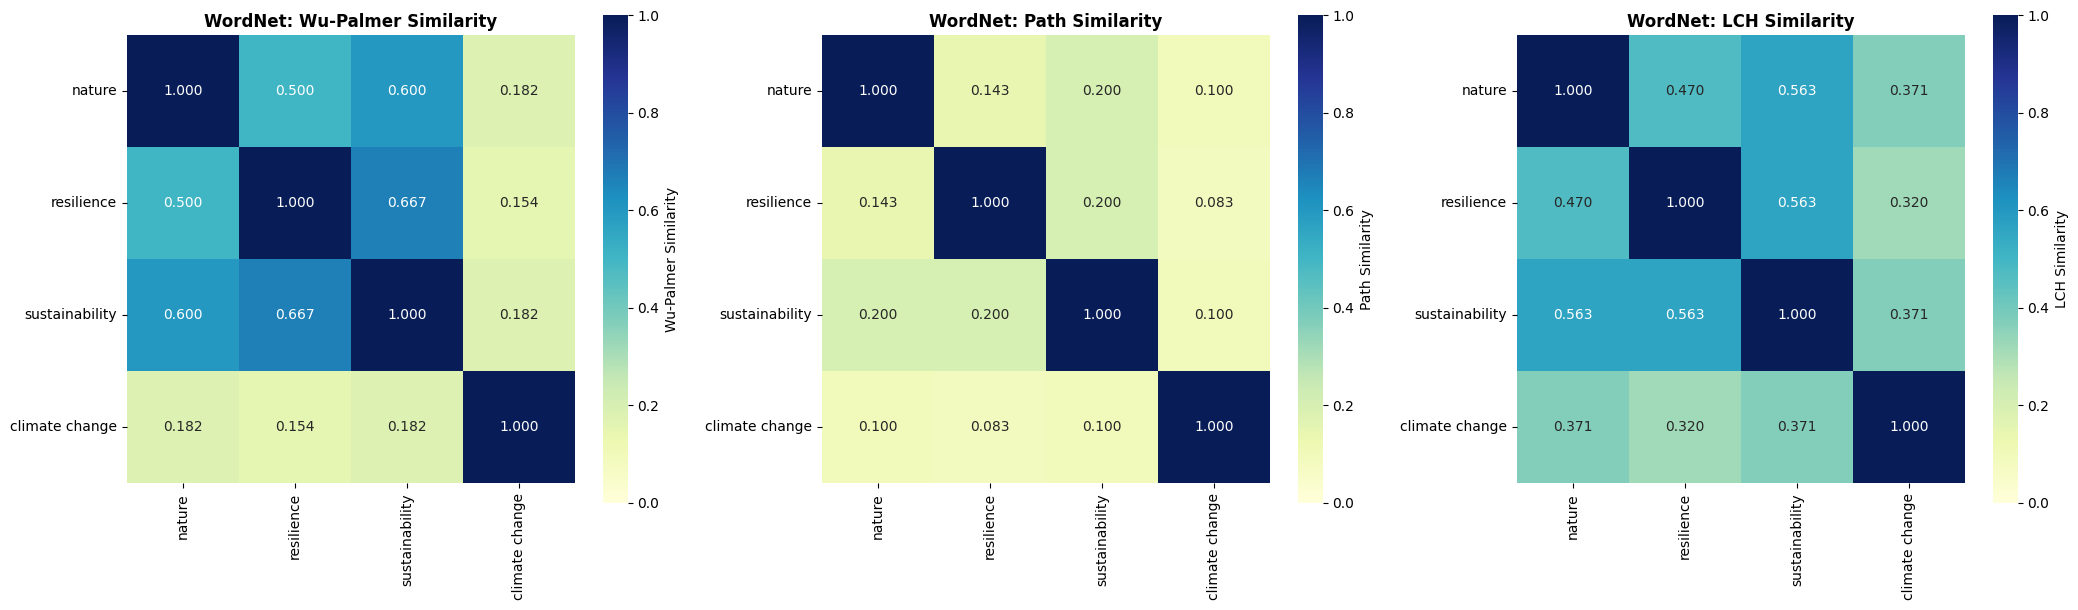


Visualization saved as 'wordnet_similarity_matrices.png'

COMPARISON: WORDNET vs WIKIPEDIA-BASED SIMILARITIES
No Wikipedia similarity files found for comparison


In [37]:
"""
Part 5: WordNet Semantic Similarity Analysis
"""

import nltk
from nltk.corpus import wordnet as wn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from itertools import combinations

# nltk.download('wordnet')
# nltk.download('omw-1.4')

class WordNetSimilarityAnalyzer:
    """
    Computes semantic similarity using NLTK WordNet.
    """
    
    def __init__(self, keywords: list):
        """
        Initialize analyzer with keywords.
        
        Args:
            keywords: List of environmental keywords to analyze
        """
        self.keywords = keywords
        self.synsets = {}
        self.similarity_matrix = None
    
    def get_best_synset(self, word: str, pos=None):
        """
        Get the most common synset for a word.
        
        Args:
            word: Word or phrase to look up
            pos: Part of speech (wn.NOUN, wn.VERB, etc.)
            
        Returns:
            Most common synset or None
        """
        word_normalized = word.lower().replace(' ', '_')
        
        synsets = wn.synsets(word_normalized, pos=pos)
        
        if not synsets:
            words = word.split()
            if len(words) > 1:
                synsets = wn.synsets(words[0], pos=pos)
        
        return synsets[0] if synsets else None
    
    def explore_synsets(self):
        """
        Display available synsets for each keyword.
        """
        
        for keyword in self.keywords:
            print(f"\n{keyword.upper()}:")
            synsets = wn.synsets(keyword.replace(' ', '_'))
            
            if not synsets:
                words = keyword.split()
                if len(words) > 1:
                    synsets = wn.synsets(words[0])
            
            if synsets:
                for i, syn in enumerate(synsets[:5], 1):
                    print(f"    {i}. {syn.name()}: {syn.definition()}")
                
                # Store the primary (most common) synset
                self.synsets[keyword] = synsets[0]
            else:
                self.synsets[keyword] = None
                print("No synsets available")
    
    def compute_wup_similarity(self):
        """
        Compute Wu-Palmer similarity for all keyword pairs.
        Wu-Palmer similarity measures similarity based on depth in WordNet taxonomy.
        Score ranges from 0 to 1 (1 = identical concepts).
        
        Returns:
            DataFrame with similarity scores
        """
        print("\n" + "="*60)
        print("COMPUTING WU-PALMER SIMILARITY")
        print("="*60)
        
        n = len(self.keywords)
        similarity_matrix = np.zeros((n, n))
        
        for i, kw1 in enumerate(self.keywords):
            for j, kw2 in enumerate(self.keywords):
                if i == j:
                    similarity_matrix[i, j] = 1.0
                elif self.synsets[kw1] and self.synsets[kw2]:
                    sim = wn.wup_similarity(
                        self.synsets[kw1], 
                        self.synsets[kw2]
                    )
                    similarity_matrix[i, j] = sim if sim else 0.0
                    
                    if i < j: 
                        print(f"{kw1} <-> {kw2}: {similarity_matrix[i, j]:.4f}")
                else:
                    similarity_matrix[i, j] = 0.0
        
        self.similarity_matrix = pd.DataFrame(
            similarity_matrix,
            index=self.keywords,
            columns=self.keywords
        )
        
        return self.similarity_matrix
    
    def compute_other_similarities(self):
        """
        Compute additional WordNet similarity metrics.
        
        Returns:
            Dictionary of similarity DataFrames
        """
        print("\n" + "="*60)
        print("ADDITIONAL WORDNET SIMILARITY METRICS")
        print("="*60)
        
        n = len(self.keywords)
        
        path_sim = np.zeros((n, n))
        lch_sim = np.zeros((n, n))
        
        for i, kw1 in enumerate(self.keywords):
            for j, kw2 in enumerate(self.keywords):
                if i == j:
                    path_sim[i, j] = 1.0
                    lch_sim[i, j] = 1.0
                elif self.synsets[kw1] and self.synsets[kw2]:
                    ps = self.synsets[kw1].path_similarity(self.synsets[kw2])
                    path_sim[i, j] = ps if ps else 0.0
                    
                    try:
                        ls = self.synsets[kw1].lch_similarity(self.synsets[kw2])
                        lch_sim[i, j] = min(ls / 3.6, 1.0) if ls else 0.0
                    except:
                        lch_sim[i, j] = 0.0
        
        return {
            'Path': pd.DataFrame(path_sim, index=self.keywords, columns=self.keywords),
            'LCH': pd.DataFrame(lch_sim, index=self.keywords, columns=self.keywords)
        }
    
    def compare_with_wikipedia(self, wiki_similarity_files: dict):
        """
        Compare WordNet similarities with Wikipedia-based similarities.
        
        Args:
            wiki_similarity_files: Dict of {name: filepath} for Wikipedia similarities
        """
        print("\n" + "="*60)
        print("COMPARISON: WORDNET vs WIKIPEDIA-BASED SIMILARITIES")
        print("="*60)
        
        # Load Wikipedia similarity matrices
        wiki_matrices = {}
        for name, filepath in wiki_similarity_files.items():
            try:
                wiki_matrices[name] = pd.read_csv(filepath, index_col=0)
            except FileNotFoundError:
                print(f"Warning: {filepath} not found, skipping")
        
        if not wiki_matrices:
            print("No Wikipedia similarity files found for comparison")
            return
        
        def get_upper_tri(df):
            mask = np.triu(np.ones_like(df), k=1).astype(bool)
            return df.values[mask]
        
        wordnet_values = get_upper_tri(self.similarity_matrix)
        
        results = []
        
        for wiki_name, wiki_df in wiki_matrices.items():
            wiki_values = get_upper_tri(wiki_df)
            
            pearson_r, pearson_p = pearsonr(wordnet_values, wiki_values)
            
            spearman_r, spearman_p = spearmanr(wordnet_values, wiki_values)
            
            results.append({
                'Representation': wiki_name,
                'Pearson r': pearson_r,
                'Pearson p-value': pearson_p,
                'Spearman ρ': spearman_r,
                'Spearman p-value': spearman_p
            })
            
            print(f"\n{wiki_name}:")
            print(f"  Pearson correlation:  r = {pearson_r:.4f} (p = {pearson_p:.4f})")
            print(f"  Spearman correlation: ρ = {spearman_r:.4f} (p = {spearman_p:.4f})")
        
        # Create comparison DataFrame
        comparison_df = pd.DataFrame(results)
        comparison_df.to_csv("wordnet_wikipedia_comparison.csv", index=False)
        
        return comparison_df
    
    def visualize_similarities(self, additional_metrics=None):
        """
        Visualize WordNet similarity matrices.
        
        Args:
            additional_metrics: Dictionary of additional similarity matrices
        """
        n_plots = 1 + (len(additional_metrics) if additional_metrics else 0)
        fig, axes = plt.subplots(1, n_plots, figsize=(7*n_plots, 6))
        
        if n_plots == 1:
            axes = [axes]
        
        # Wu-Palmer similarity
        sns.heatmap(
            self.similarity_matrix,
            annot=True,
            fmt='.3f',
            cmap='YlGnBu',
            square=True,
            ax=axes[0],
            vmin=0, vmax=1,
            cbar_kws={'label': 'Wu-Palmer Similarity'}
        )
        axes[0].set_title('WordNet: Wu-Palmer Similarity', 
                         fontsize=12, fontweight='bold')
        
        if additional_metrics:
            for idx, (name, df) in enumerate(additional_metrics.items(), 1):
                sns.heatmap(
                    df,
                    annot=True,
                    fmt='.3f',
                    cmap='YlGnBu',
                    square=True,
                    ax=axes[idx],
                    vmin=0, vmax=1,
                    cbar_kws={'label': f'{name} Similarity'}
                )
                axes[idx].set_title(f'WordNet: {name} Similarity', 
                                   fontsize=12, fontweight='bold')
        
        plt.tight_layout()
        plt.savefig('wordnet_similarity_matrices.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("\nVisualization saved as 'wordnet_similarity_matrices.png'")


def main():
    """
    Main execution for WordNet similarity analysis.
    """
    keywords = ["nature", "resilience", "sustainability", "climate change"]
    
    analyzer = WordNetSimilarityAnalyzer(keywords)
    
    analyzer.explore_synsets()
    
    wup_similarity = analyzer.compute_wup_similarity()
    
    print("\n" + "="*60)
    print("WU-PALMER SIMILARITY MATRIX")
    print("="*60)
    print(wup_similarity.to_string())
    wup_similarity.to_csv("similarity_matrix_wordnet_wup.csv")
    
    # Compute additional metrics
    other_metrics = analyzer.compute_other_similarities()
    
    print("\n" + "="*60)
    print("PATH SIMILARITY MATRIX")
    print("="*60)
    print(other_metrics['Path'].to_string())
    
    # Visualize
    analyzer.visualize_similarities(other_metrics)
    
    # Compare with Wikipedia-based similarities
    wiki_files = {
        'Full Text': 'similarity_matrix_fulltext.csv',
        'Subsections': 'similarity_matrix_subsections.csv',
        'Entities': 'similarity_matrix_entities.csv'
    }
    
    comparison_df = analyzer.compare_with_wikipedia(wiki_files)
    
    
 
    if comparison_df is not None:
        best_correlation = comparison_df.loc[
            comparison_df['Pearson r'].idxmax()
        ]
        print(f"\n BEST WIKIPEDIA REPRESENTATION:")
        print(f"'{best_correlation['Representation']}' shows strongest")
        print(f"correlation with WordNet (r = {best_correlation['Pearson r']:.4f})")


if __name__ == "__main__":
    main()

In [38]:
#Part 6:
#scraping the content of each entity with beautiful soup and retrieving all the entity-category
#Wikipedia has limitations for Web Scraping (https://en.wikipedia.org/robots.txt)

import time
import requests
from bs4 import BeautifulSoup
from urllib.parse import quote
from collections import defaultdict
import pickle
import json

class WikipediaEntityExpander:
    #Expands entity network by scraping connected Wikipedia pages.
    
    def __init__(self, max_entities_per_keyword=50, delay=0.5): #must put delay because of Wikipedia
        #Initialize scraper.
        self.max_entities = max_entities_per_keyword
        self.delay = delay
        self.session = requests.Session()
        self.session.headers.update({
            'User-Agent': 'EnvironmentKeywordMapping/1.0 (University Research Project)'
        })
        self.expanded_data = defaultdict(dict)

    def load_initial_entities(self, data_file: str, keywords: list) -> dict:
        #Load initial entities from Wikipedia data.
        with open(data_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        entity_dict = {}
        for keyword in keywords:
            if keyword in data:
                entities = data[keyword].get('entities', [])[:self.max_entities]
                entity_dict[keyword] = entities
                print(f"{keyword}: {len(entities)} entities to expand")
        
        return entity_dict

    def scrape_entity_page(self, entity_name: str) -> dict:
        #Scrape a single Wikipedia entity page.
        url = f"https://en.wikipedia.org/wiki/{quote(entity_name)}"
        
        try:
            response = self.session.get(url, timeout=10)
            response.raise_for_status()
            soup = BeautifulSoup(response.content, 'html.parser')
            
            #Extract categories from category links
            categories = []
            category_div = soup.find('div', {'id': 'mw-normal-catlinks'})
            if category_div:
                category_links = category_div.find_all('a')
                categories = [
                    link.text for link in category_links
                    if not link.text.startswith('Category:')
                ]
            
            #Extract first paragraph text
            first_para = soup.find('p')
            summary = first_para.get_text() if first_para else ""
            
            #Extract linked entities from first section
            content_div = soup.find('div', {'id': 'mw-content-text'})
            linked_entities = []
            if content_div:
                #Get first few paragraphs
                paragraphs = content_div.find_all('p', limit=3)
                for para in paragraphs:
                    links = para.find_all('a', href=True)
                    for link in links:
                        href = link.get('href', '')
                        if href.startswith('/wiki/') and ':' not in href:
                            entity = href.replace('/wiki/', '')
                            linked_entities.append(entity)
            
            return {
                'entity_name': entity_name,
                'url': url,
                'categories': categories,
                'summary': summary[:500], #First 500 chars
                'linked_entities': list(set(linked_entities))[:20], #First 20 unique
                'scraped': True
            }
            
        except Exception as e:
            print(f"Error scraping {entity_name}: {e}")
            return {
                'entity_name': entity_name,
                'url': url,
                'categories': [],
                'summary': "",
                'linked_entities': [],
                'scraped': False,
                'error': str(e)
            }

    def expand_entities(self, entity_dict: dict) -> dict:
        #Expand entities by scraping their Wikipedia pages.
        print()
        print("EXPANDING ENTITY NETWORK")
        print()
        
        for keyword, entities in entity_dict.items():
            print()
            print(f"Processing: {keyword}")
            print(f" Entities to scrape: {len(entities)}")
            print()
            
            self.expanded_data[keyword] = {}
            
            for i, entity in enumerate(entities, 1):
                #Scrape entity page
                entity_data = self.scrape_entity_page(entity)
                self.expanded_data[keyword][entity] = entity_data
                
                #add delay between requests
                time.sleep(self.delay)
                
        return dict(self.expanded_data)

    def create_expanded_corpus(self) -> dict:
        #Create expanded corpus from scraped entity data.
        expanded_corpus = {}
        print()
        print("Expanded entity corpus")
        
        for keyword, entities_data in self.expanded_data.items():
            #Combine all categories from all entities
            all_categories = []
            all_summaries = []
            all_linked_entities = []
            
            for entity_name, entity_info in entities_data.items():
                if entity_info['scraped']:
                    all_categories.extend(entity_info['categories'])
                    all_summaries.append(entity_info['summary'])
                    all_linked_entities.extend(entity_info['linked_entities'])
            
            expanded_corpus[keyword] = {
                'categories_text': ' '.join(all_categories),
                'summaries_text': ' '.join(all_summaries),
                'linked_entities_text': ' '.join(all_linked_entities),
                'num_entities_scraped': sum(
                    1 for e in entities_data.values() if e['scraped']
                ),
                'total_categories': len(all_categories),
                'total_linked_entities': len(set(all_linked_entities))
            }
            
            print(f"\n{keyword}:")
            print(f" Entities scraped: {expanded_corpus[keyword]['num_entities_scraped']}")
            print(f" Total categories: {expanded_corpus[keyword]['total_categories']}")
            print(f" Total linked entities: {expanded_corpus[keyword]['total_linked_entities']}")
        
        return expanded_corpus

    def save_expanded_data(self, filename='expanded_entity_data.pkl'):
        #Save expanded data to pickle file.
        with open(filename, 'wb') as f:
            pickle.dump(dict(self.expanded_data), f)
        print(f"Expanded data saved to {filename}")

    def save_expanded_corpus(self, expanded_corpus: dict, filename='expanded_corpus.json'):
        #Save expanded corpus to JSON.
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(expanded_corpus, f, indent=2, ensure_ascii=False)
        print(f"Expanded corpus saved to {filename}")

#Main program
keywords = ["nature", "resilience", "sustainability", "climate change"]

print()
print("Entity expansion, web scraping")
print()

#Initialize expander
expander = WikipediaEntityExpander(
    max_entities_per_keyword=30, #Limit for demonstration
    delay=0.5 #500ms delay between requests because of Wikipedia's terms
)

#Load initial entities
entity_dict = expander.load_initial_entities(
    "wikipedia_all_keywords.json",
    keywords
)

#Expand entities
expanded_data = expander.expand_entities(entity_dict)

#Create expanded corpus
expanded_corpus = expander.create_expanded_corpus()

#Save results
print()
expander.save_expanded_data()
expander.save_expanded_corpus(expanded_corpus)


Entity expansion, web scraping

nature: 30 entities to expand
resilience: 30 entities to expand
sustainability: 30 entities to expand
climate change: 30 entities to expand

EXPANDING ENTITY NETWORK


Processing: nature
 Entities to scrape: 30


Processing: resilience
 Entities to scrape: 30


Processing: sustainability
 Entities to scrape: 30


Processing: climate change
 Entities to scrape: 30


Expanded entity corpus

nature:
 Entities scraped: 30
 Total categories: 197
 Total linked entities: 415

resilience:
 Entities scraped: 30
 Total categories: 223
 Total linked entities: 247

sustainability:
 Entities scraped: 30
 Total categories: 230
 Total linked entities: 365

climate change:
 Entities scraped: 30
 Total categories: 320
 Total linked entities: 324

Expanded data saved to expanded_entity_data.pkl
Expanded corpus saved to expanded_corpus.json



----- expanded_corpus.json


TF-IDF similarity - expanded CATEGORIES


Similarity Matrix (categories):
                  nature  resilience  sustainability  climate change
nature          1.000000    0.236758        0.308552        0.328945
resilience      0.236758    1.000000        0.413677        0.487823
sustainability  0.308552    0.413677        1.000000        0.555742
climate change  0.328945    0.487823        0.555742        1.000000

TF-IDF similarity - expanded SUMMARIES


Similarity Matrix (summaries):
                  nature  resilience  sustainability  climate change
nature          1.000000    0.678169        0.689246        0.546126
resilience      0.678169    1.000000        0.726044        0.595223
sustainability  0.689246    0.726044        1.000000        0.607149
climate change  0.546126    0.595223        0.607149        1.000000

TF-IDF similarity - expanded LINKED_ENTITIES


Similarity Matrix (linked_entities):
                  nature  resilience  sustainabi

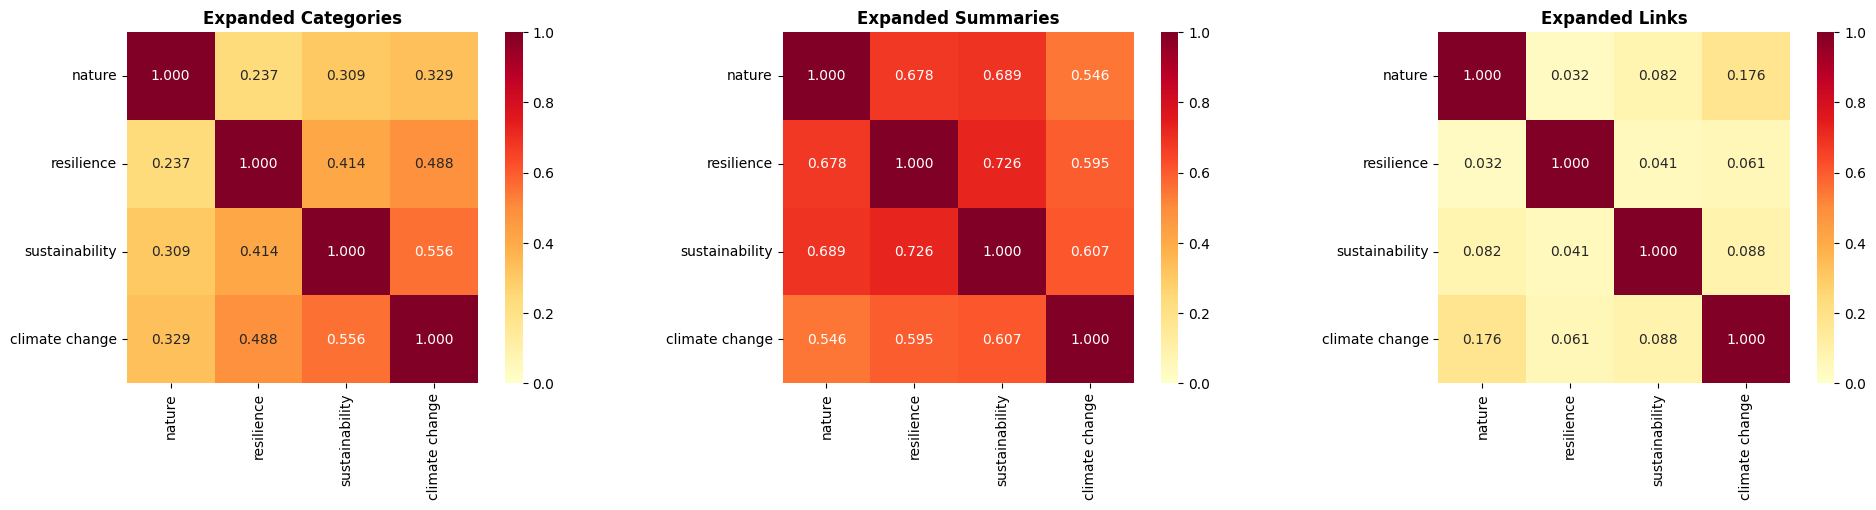


Model: glove-wiki-gigaword-100

Model loaded: 400000 words in vocabulary
Embedding dimension: 100


Word2Vec Similarity Matrix:
                  nature  resilience  sustainability  climate change
nature          1.000000    0.330315        0.375072        0.616774
resilience      0.330315    1.000000        0.468170        0.286923
sustainability  0.375072    0.468170        1.000000        0.511735
climate change  0.616774    0.286923        0.511735        1.000000

Visualization



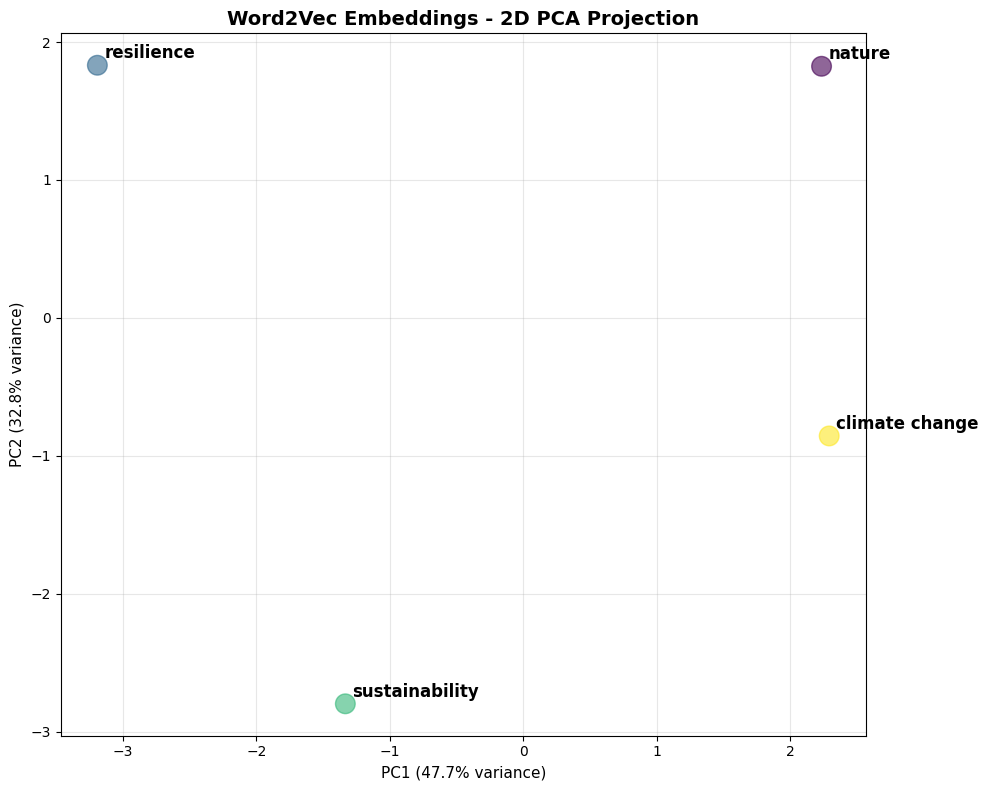

In [39]:
#Parts 7-8: 
#Repeating the TfIdfVectorizer representation and recalculating the cosine similarityrresponding similarity.

import gensim.downloader as api
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


class ExpandedEntityAnalyzer:
    #Analyzes similarity using expanded entity network data.
    
    def __init__(self, keywords: list):
        #Initialize with keywords.
        self.keywords = keywords
        self.expanded_corpus = None
    
    def load_expanded_corpus(self, filename='expanded_corpus.json'):
        #Load expanded corpus from JSON.
        with open(filename, 'r', encoding='utf-8') as f:
            print('-----', filename)
            self.expanded_corpus = json.load(f)
        print()
        for keyword in self.keywords:
            if keyword in self.expanded_corpus:
                stats = self.expanded_corpus[keyword]
   
    def build_tfidf_similarity(self, representation='categories'):
        #Build TF-IDF similarity using expanded data.
        print()
        print(f"TF-IDF similarity - expanded {representation.upper()}")
        print()
        # Build corpus
        corpus = []
        text_key = f'{representation}_text'
        
        for keyword in self.keywords:
            if keyword in self.expanded_corpus:
                corpus.append(self.expanded_corpus[keyword][text_key])
            else:
                corpus.append("")
        
        # TF-IDF vectorization
        vectorizer = TfidfVectorizer(
            max_features=1000,
            min_df=1,
            lowercase=True
        )
        
        tfidf_matrix = vectorizer.fit_transform(corpus)
 
        # Compute similarity
        similarity_matrix = cosine_similarity(tfidf_matrix)
        
        df_similarity = pd.DataFrame(
            similarity_matrix,
            index=self.keywords,
            columns=self.keywords
        )
        
        print(f"\nSimilarity Matrix ({representation}):")
        print(df_similarity.to_string())
        
        return df_similarity
    
    def compare_all_representations(self):
        #Compare all expanded entity representations.
        
        representations = {
            'Expanded Categories': self.build_tfidf_similarity('categories'),
            'Expanded Summaries': self.build_tfidf_similarity('summaries'),
            'Expanded Links': self.build_tfidf_similarity('linked_entities')
        }
        
        # Visualize
        fig, axes = plt.subplots(1, 3, figsize=(20, 5))
        
        for idx, (name, df) in enumerate(representations.items()):
            sns.heatmap(
                df,
                annot=True,
                fmt='.3f',
                cmap='YlOrRd',
                square=True,
                ax=axes[idx],
                vmin=0, vmax=1
            )
            axes[idx].set_title(name, fontsize=12, fontweight='bold')
        
        plt.tight_layout()
        plt.savefig('expanded_entity_similarities.png', dpi=300)
        plt.show()
        
        # Save all matrices
        for name, df in representations.items():
            filename = f"similarity_matrix_{name.lower().replace(' ', '_')}.csv"
            df.to_csv(filename)
        
        return representations


class Word2VecSimilarityAnalyzer:
    #Computes similarity using pre-trained Word2Vec embeddings.
    
    def __init__(self, keywords: list):
        #Initialize analyzer.

        self.keywords = keywords
        self.model = None
        self.embeddings = {}
    
    def load_pretrained_model(self, model_name='glove-wiki-gigaword-100'):
        #Load pre-trained word embeddings.
        print()
        print(f"Model: {model_name}")
        print()
        
        try:
            self.model = api.load(model_name)
            print(f"Model loaded: {len(self.model)} words in vocabulary")
            print(f"Embedding dimension: {self.model.vector_size}")
        except Exception as e:
            print(f"Error loading model: {e}")
            print("Falling back to glove-wiki-gigaword-50 (smaller model)")
            self.model = api.load('glove-wiki-gigaword-50')
    
    def get_keyword_embeddings(self):
        #Get embeddings for each keyword. Handles multi-word terms by averaging word vectors.

        for keyword in self.keywords:
            words = keyword.lower().split()
            
            # Collect vectors for words in vocabulary
            vectors = []
            found_words = []
            
            for word in words:
                if word in self.model:
                    vectors.append(self.model[word])
                    found_words.append(word)
                else:
                    # Try with underscore (for compound terms)
                    compound = '_'.join(words)
                    if compound in self.model:
                        vectors.append(self.model[compound])
                        found_words.append(compound)
            
            if vectors:
                # Average word vectors for multi-word terms
                embedding = np.mean(vectors, axis=0)
                self.embeddings[keyword] = embedding
            else:
                print(f"\n{keyword}:")
                print(f"No words found in vocabulary!")
                # Use zero vector as fallback
                self.embeddings[keyword] = np.zeros(self.model.vector_size)
    
    def compute_similarity_matrix(self) -> pd.DataFrame:
        #Compute cosine similarity using Word2Vec embeddings.
        print()
        n = len(self.keywords)
        similarity_matrix = np.zeros((n, n))
        
        for i, kw1 in enumerate(self.keywords):
            for j, kw2 in enumerate(self.keywords):
                # Compute cosine similarity
                vec1 = self.embeddings[kw1]
                vec2 = self.embeddings[kw2]
                
                # Cosine similarity = dot product / (norm1 * norm2)
                norm1 = np.linalg.norm(vec1)
                norm2 = np.linalg.norm(vec2)
                
                if norm1 > 0 and norm2 > 0:
                    similarity_matrix[i, j] = np.dot(vec1, vec2) / (norm1 * norm2)
                else:
                    similarity_matrix[i, j] = 0.0
        
        df_similarity = pd.DataFrame(
            similarity_matrix,
            index=self.keywords,
            columns=self.keywords
        )
        
        print("\nWord2Vec Similarity Matrix:")
        print(df_similarity.to_string())
        
        return df_similarity

    def visualize_embeddings_2d(self):
        #Visualize keyword embeddings.
        
        from sklearn.decomposition import PCA
        
        print()
        print("Visualization")
        print()
        
        # Stack embeddings
        embedding_matrix = np.vstack([
            self.embeddings[kw] for kw in self.keywords
        ])
        
        # Reduce to 2D with PCA
        pca = PCA(n_components=2)
        embeddings_2d = pca.fit_transform(embedding_matrix)
        
        # Plot
        plt.figure(figsize=(10, 8))
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                   s=200, alpha=0.6, c=range(len(self.keywords)), 
                   cmap='viridis')
        
        for i, keyword in enumerate(self.keywords):
            plt.annotate(
                keyword,
                (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                fontsize=12,
                fontweight='bold',
                xytext=(5, 5),
                textcoords='offset points'
            )
        
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', 
                  fontsize=11)
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', 
                  fontsize=11)
        plt.title('Word2Vec Embeddings - 2D PCA Projection', 
                 fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        
#Main program
    
keywords = ["nature", "resilience", "sustainability", "climate change"]
    
#Part 7
print()

try:
    expanded_analyzer = ExpandedEntityAnalyzer(keywords)
    expanded_analyzer.load_expanded_corpus()
    expanded_representations = expanded_analyzer.compare_all_representations()
        
except FileNotFoundError:
    print("Expanded corpus not found.")

#Part 8

w2v_analyzer = Word2VecSimilarityAnalyzer(keywords)
    
#Pre-trained model
w2v_analyzer.load_pretrained_model('glove-wiki-gigaword-100')
    
#Embeddings
w2v_analyzer.get_keyword_embeddings()
    
#Similarity
w2v_similarity = w2v_analyzer.compute_similarity_matrix()
w2v_similarity.to_csv("similarity_matrix_word2vec.csv")
    
#Visualizing embeddings
w2v_analyzer.visualize_embeddings_2d()


Processing period: 2025-10-07_to_2025-11-06


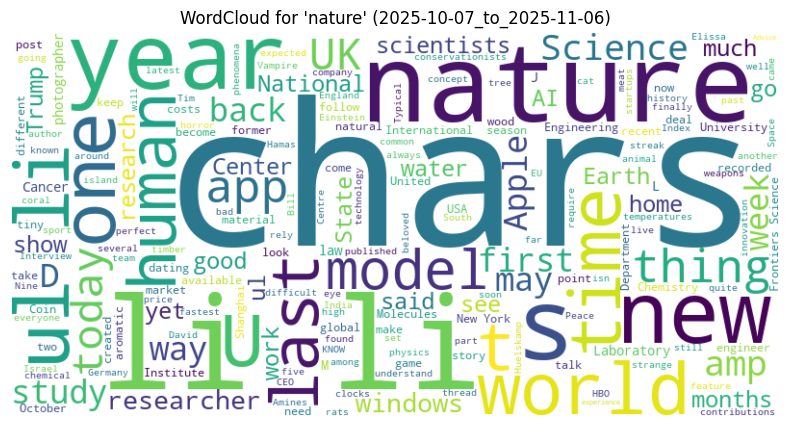

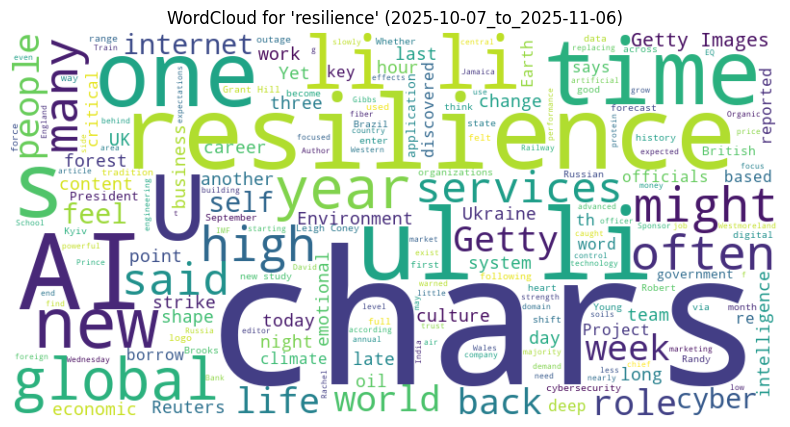

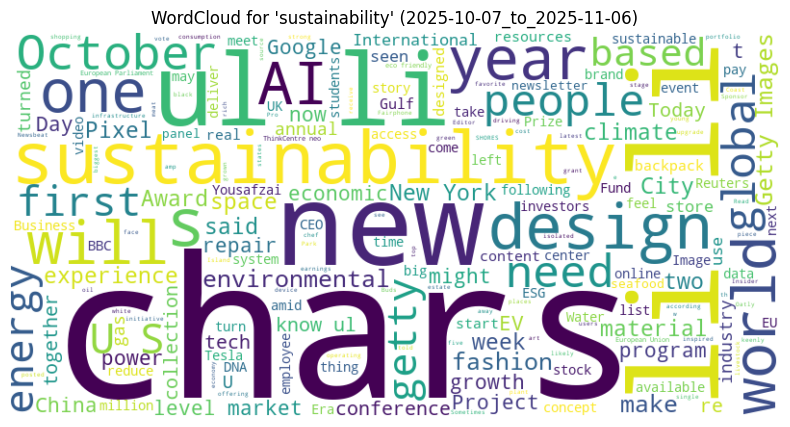

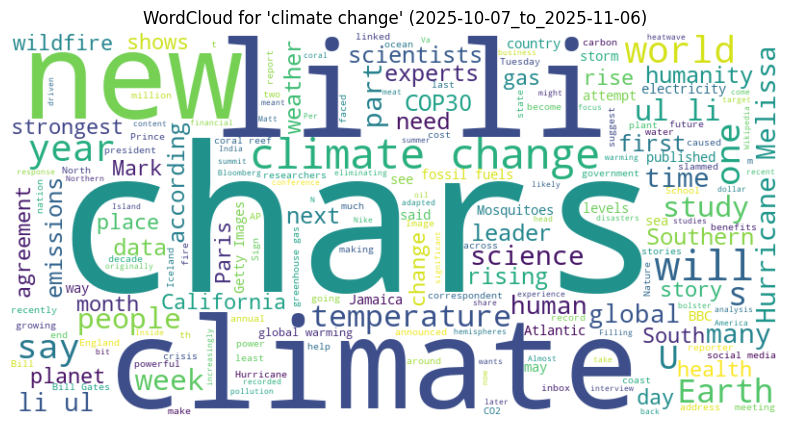

Keyword 'nature': 3346 words combined
Keyword 'resilience': 3377 words combined
Keyword 'sustainability': 3294 words combined
Keyword 'climate change': 3369 words combined

TF-IDF Cosine Similarity for period 2025-10-07_to_2025-11-06:


,nature,resilience,sustainability,climate change
nature,1.000000,0.705781,0.728490,0.688003
resilience,0.705781,1.000000,0.719233,0.689059
sustainability,0.728490,0.719233,1.000000,0.689634
climate change,0.688003,0.689059,0.689634,1.000000


Keyword 'nature': 3346 words combined
Keyword 'resilience': 3377 words combined
Keyword 'sustainability': 3294 words combined
Keyword 'climate change': 3369 words combined

Word2Vec Cosine Similarity for period 2025-10-07_to_2025-11-06:


,nature,resilience,sustainability,climate change
nature,1.000000,0.974820,0.964668,0.948826
resilience,0.974820,1.000000,0.970757,0.964026
sustainability,0.964668,0.970757,1.000000,0.943835
climate change,0.948826,0.964026,0.943835,1.000000



    # Step 11: Commentary on Similarity Results

    The analysis of news content across the keywords **nature**, **resilience**, **sustainability**, and **climate change** shows two types of similarity: lexical similarity (TF-IDF) and semantic similarity (Word2Vec).

    ## Observations

    ### TF-IDF Similarity
    - Values range between 0.68 – 0.73 for most keyword pairs.
    - Indicates moderate lexical overlap in the news articles; keywords like nature and sustainability may share common vocabulary, but wording differs across articles.
    - TF-IDF captures frequency of exact terms but cannot detect synonymy or contextual similarity.

    ### Word2Vec Similarity
    - Values are very high, between 0.94 – 0.97, indicating strong semantic similarity.
    - Even when exact words differ, Word2Vec embeddings detect that these concepts occur in similar contexts across the news articles.
    - This aligns with the expectation that news about climate change often involves discussions on resilience and sustainability, even if different terms are used.

    ## Interpretation
    - TF-IDF results reflect lexical overlap, capturing direct word usage. Moderate values suggest that while keywords are related, journalists use varied vocabulary.
    - Word2Vec results reflect semantic similarity, capturing underlying meaning. High similarity indicates that these concepts are conceptually connected in the news discourse.
    - Comparing TF-IDF and Word2Vec highlights the difference between surface-level word matching versus deep contextual understanding.

    ## Implications
    - For trend analysis and topic clustering in news, Word2Vec or other embedding-based approaches may give a more meaningful similarity measure.
    - TF-IDF is still useful for understanding word usage patterns and keyword co-occurrences.

    ## Literature References
    - Manning et al., 2008 – *Introduction to Information Retrieval*: TF-IDF captures term frequency importance but is limited to lexical similarity.
    - Mikolov et al., 2013 – *Efficient Estimation of Word Representations in Vector Space*: Word2Vec embeddings capture semantic similarity from context co-occurrence.
    

In [40]:
# Task 9, 10, 11: News Data Analysis Over Time Periods
import task9_news as t9
import pandas as pd
from IPython.display import display, Markdown


keywords = ["nature", "resilience", "sustainability", "climate change"]

periods = t9.get_time_periods(months=1)

all_data = []

for start, end in periods:
    period_label = f"{start}_to_{end}"
    print(f"\nProcessing period: {period_label}")

    df_period = t9.fetch_news(keywords, (start, end))
    if df_period.empty:
        print(f"No news found for period {period_label}, skipping further steps.")
        continue

    df_period.to_csv(f"news_dataset_{period_label}.csv", index=False)

    t9.generate_wordcloud(df_period, period_label)

    tfidf_sim = t9.compute_tfidf_similarity(df_period)
    tfidf_sim.to_csv(f"tfidf_similarity_{period_label}.csv")
    
    print(f"\nTF-IDF Cosine Similarity for period {period_label}:")
    display(tfidf_sim)

    w2v_sim = t9.compute_w2v_similarity(df_period)
    w2v_sim.to_csv(f"w2v_similarity_{period_label}.csv")
    
    print(f"\nWord2Vec Cosine Similarity for period {period_label}:")
    display(w2v_sim)

    all_data.append(df_period)
    display(Markdown(t9.commentary))

if all_data:
    df_all = pd.concat(all_data, ignore_index=True)
    df_all.to_csv("news_dataset_all_periods.csv", index=False)
